In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import itertools
from PIL import Image, ImageChops, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [4]:
image_size = (128, 128)
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [5]:
X = [] # ELA converted images
Y = [] # 0 for forged, 1 for authentic

In [6]:
# Load authentic images
path = 'dataset/authentic'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)

In [7]:
# Load forged images
path = 'dataset/forged'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)

In [8]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [12]:
base_model_incep = InceptionV3(input_shape=(128, 128, 3),
                               include_top=False, weights='imagenet')

for layer in base_model_incep.layers:
    layer.trainable = False

x_incep = layers.Flatten()(base_model_incep.output)
x_incep = layers.Dense(1024, activation='relu')(x_incep)
x_incep = layers.Dropout(0.2)(x_incep)
x_incep = layers.Dense(2, activation='softmax')(x_incep)

model_incep = tf.keras.models.Model(base_model_incep.input, x_incep)

model_incep.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

mc_incep = ModelCheckpoint(filepath="./incep_best_model.keras",
                                              monitor='val_accuracy',
                                              verbose=1,
                                              save_best_only=True,
                                              mode='auto')

incep_callbacks = [mc_incep]

incep_history = model_incep.fit(X_train, Y_train,
                                epochs=32,
                                validation_data=(X_val, Y_val),
                                callbacks=incep_callbacks)

model_incep.save('model_incep.keras')

Epoch 1/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6375 - loss: 2.0019
Epoch 1: val_accuracy improved from -inf to 0.82000, saving model to ./incep_best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.6390 - loss: 1.9853 - val_accuracy: 0.8200 - val_loss: 0.3650
Epoch 2/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8683 - loss: 0.3151
Epoch 2: val_accuracy did not improve from 0.82000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.8680 - loss: 0.3162 - val_accuracy: 0.7575 - val_loss: 0.5605
Epoch 3/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8884 - loss: 0.2534
Epoch 3: val_accuracy improved from 0.82000 to 0.83750, saving model to ./incep_best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.8886 - loss: 0.2533 - val_accuracy: 0.8375 - val_loss: 0.3455
Epoch 4/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9157 - loss: 0.1962
Epoch 4: val_accuracy did not improve from 0.83750
50/50 ━━━━━

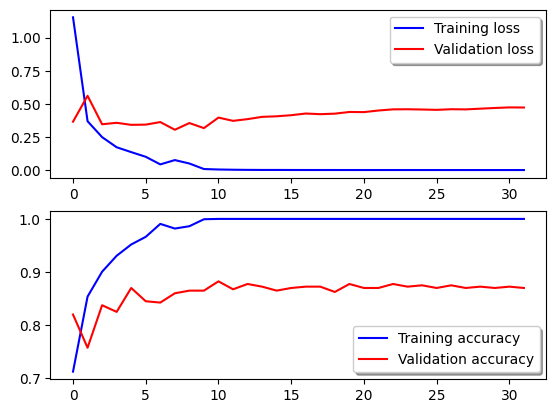

In [13]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(incep_history.history['loss'], color='b', label="Training loss")
ax[0].plot(incep_history.history['val_loss'], color='r', label="Validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(incep_history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(incep_history.history['val_accuracy'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step


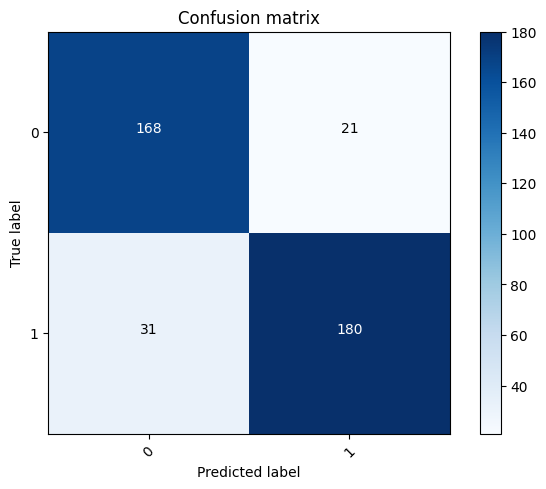

In [14]:
Y_pred_incep = model_incep.predict(X_val)
Y_pred_classes_incep = np.argmax(Y_pred_incep, axis=1)
Y_true_incep = np.argmax(Y_val, axis=1)
confusion_mtx_incep = confusion_matrix(Y_true_incep, Y_pred_classes_incep)
plot_confusion_matrix(confusion_mtx_incep, classes=range(2))

In [15]:
print("Classification report for InceptionV3:")
print(classification_report(Y_true_incep, Y_pred_classes_incep, target_names=['forged', 'authentic']))
accuracy_incep = accuracy_score(Y_true_incep, Y_pred_classes_incep)
print("Overall accuracy for InceptionV3: {:.2f}%".format(accuracy_incep*100))

Classification report for InceptionV3:
              precision    recall  f1-score   support

      forged       0.84      0.89      0.87       189
   authentic       0.90      0.85      0.87       211

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400

Overall accuracy for InceptionV3: 87.00%


In [29]:
sample_paths = [
    'dataset/authentic/33.jpg',
    'dataset/authentic/34.jpg',
    'dataset/authentic/35.jpg',
    'dataset/authentic/335.jpg',
    'dataset/authentic/336.jpg',
    'dataset/authentic/337.jpg',
    'dataset/authentic/338.jpg',
    'dataset/authentic/339.jpg',
    'dataset/forged/1257_1258.png',
    'dataset/forged/1259_1260.png',
    'dataset/forged/1261_1262.png',
    'dataset/forged/1262_1263.png',
    'dataset/forged/1265_1266.png',
    'dataset/forged/1266_1267.png',
    'dataset/forged/1269_1270.png',
    'dataset/forged/1271_1272.png',
    'dataset/forged/1273_1274.png',
    'dataset/forged/1276_1277.png',
]

In [30]:
for sample_path in sample_paths:
    image = prepare_image(sample_path)
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model_incep.predict(image)
    y_pred_class = np.argmax(y_pred, axis = 1)[0]
    class_names = ['forged', 'authentic']
    print(f'Image: {sample_path}, Predicted class: {class_names[y_pred_class]}, Confidence: {np.amax(y_pred) * 100:0.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: dataset/authentic/33.jpg, Predicted class: authentic, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: dataset/authentic/34.jpg, Predicted class: authentic, Confidence: 99.99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: dataset/authentic/35.jpg, Predicted class: authentic, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image: dataset/authentic/335.jpg, Predicted class: authentic, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image: dataset/authentic/336.jpg, Predicted class: authentic, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image: dataset/authentic/337.jpg, Predicted class: authentic, Confidence: 99.99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image: dataset/authentic/338.jpg, Predicted class: authentic, Confidence: 99.99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: dataset/authentic/339.jpg, Predicted class: authentic, Confidence: 99.99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: da

In [33]:
correct = 0
total = 0

for dirname, _, filenames in os.walk('dataset/forged'):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            image_path = os.path.join(dirname, filename)
            image = prepare_image(image_path)
            image = image.reshape(-1, 128, 128, 3)
            y_pred = model_incep.predict(image)
            y_pred_class = np.argmax(y_pred, axis = 1)[0]
            total += 1
            if y_pred_class == 0:
                correct += 1

for dirname, _, filenames in os.walk('dataset/authentic'):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            image_path = os.path.join(dirname, filename)
            image = prepare_image(image_path)
            image = image.reshape(-1, 128, 128, 3)
            y_pred = model_incep.predict(image)
            y_pred_class = np.argmax(y_pred, axis = 1)[0]
            total += 1
            if y_pred_class == 1:
                correct += 1

print(f'Total: {total}, Correct: {correct}, Accuracy: {correct / total * 100.0:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━